# **Magic Makeup**
This notebook applies virtual makeup (lipstick, blush, eyeshadow) to face images using MediaPipe's facial landmark detection.

## Setup Environment

In [1]:
# restart session if error occurs
!pip install mediapipe==0.10.14 opencv-python==4.7.0.72 numpy==1.26.4

## Color Extractor

In [2]:
import io
import math
import time
import uuid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from io import BytesIO
from collections import Counter
from skimage import color

from google.colab import files
from google.colab.output import eval_js

from IPython.display import HTML, display
from base64 import b64decode
import base64

import cv2
from PIL import Image

In [3]:
# --- define parameters ---
COSMETIC_TYPE = {
    "lip_full": "💄",
    "lip_half": "💋",
    "blush": "😳",
    "eyeshadow_basic": "👁️",
    "eyeshadow_undereye": "👀",
    "eyeshadow_triangle": "👁️🔺",
    "eyebrow": "🖌️"
}

In [4]:
# ------------------ Utils ---------------------
def canvas_html_format(unique_id, w, h, line_width, img_b64):
    """
    Generate Canvas HTML with unique IDs
    """
    return f"""
    <canvas id="canvas_{unique_id}" width="{w}" height="{h}" style="border:2px solid red; cursor:crosshair;"></canvas>
    <div style="margin-top:10px;">
      <button id="save_{unique_id}" style="padding:10px 20px; font-size:16px; cursor:pointer; background:#4CAF50; color:white; border:none; border-radius:5px;">✅ Save Drawing</button>
      <button id="clear_{unique_id}" style="padding:10px 20px; font-size:16px; cursor:pointer; background:#f44336; color:white; border:none; border-radius:5px; margin-left:10px;">🗑️ Clear</button>
      <label style="margin-left:20px; font-weight:bold;">Brush Size:
        <input type="range" id="lineWidth_{unique_id}" min="1" max="50" value="{line_width}" style="width:200px;">
        <span id="widthValue_{unique_id}">{line_width}</span>px
      </label>
    </div>
    <script>
    (function() {{
      var canvas = document.getElementById('canvas_{unique_id}');
      var ctx = canvas.getContext('2d');

      // load background img
      var bgImage = new Image();
      bgImage.src = 'data:image/png;base64,{img_b64}';
      bgImage.onload = function() {{
        ctx.drawImage(bgImage, 0, 0, canvas.width, canvas.height);
      }};

      var drawing = false;
      var lineWidth = {line_width};

      // adjust brush size
      document.getElementById('lineWidth_{unique_id}').addEventListener('input', function(e) {{
        lineWidth = e.target.value;
        document.getElementById('widthValue_{unique_id}').textContent = lineWidth;
      }});

      // mouse event
      canvas.addEventListener('mousedown', function(e) {{
        drawing = true;
        ctx.beginPath();
        var rect = canvas.getBoundingClientRect();
        ctx.moveTo(e.clientX - rect.left, e.clientY - rect.top);
      }});

      canvas.addEventListener('mousemove', function(e) {{
        if (drawing) {{
          var rect = canvas.getBoundingClientRect();
          ctx.lineTo(e.clientX - rect.left, e.clientY - rect.top);
          ctx.strokeStyle = 'rgba(255, 0, 0, 0.7)';
          ctx.lineWidth = lineWidth;
          ctx.lineCap = 'round';
          ctx.lineJoin = 'round';
          ctx.stroke();
        }}
      }});

      canvas.addEventListener('mouseup', function() {{
        drawing = false;
      }});

      canvas.addEventListener('mouseout', function() {{
        drawing = false;
      }});

      // clear button
      document.getElementById('clear_{unique_id}').addEventListener('click', function() {{
        ctx.clearRect(0, 0, canvas.width, canvas.height);
        ctx.drawImage(bgImage, 0, 0, canvas.width, canvas.height);
        document.getElementById('save_{unique_id}').textContent = 'Save Drawing';
        document.getElementById('save_{unique_id}').style.backgroundColor = '#4CAF50';
      }});

      // save button
      window.getDrawingData_{unique_id} = function() {{
        return canvas.toDataURL('image/png');
      }};

      document.getElementById('save_{unique_id}').addEventListener('click', function() {{
        this.textContent = 'Saved!';
        this.style.backgroundColor = '#2196F3';
        console.log('Drawing ready to save');
      }});
    }})();
    </script>
    """

def save_masked_image(image_path, output_filename, cosmetic_type):
    # Load marked image (the one with red regions)
    marked = np.array(plt.imread(output_filename)[:, :, :3])

    # Detect red region (bright red)
    mask = (marked[:, :, 0] > 0.9) & (marked[:, :, 1] < 0.1) & (marked[:, :, 2] < 0.1)
    mask = mask.astype(np.uint8)

    # Load original image
    original = np.array(Image.open(image_path))

    # Resize mask to original resolution
    mask_resized = cv2.resize(
        mask,
        (original.shape[1], original.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )

    # Save binary mask
    mask_filename = f"{cosmetic_type}_mask_binary.png"
    Image.fromarray((mask_resized * 255).astype(np.uint8)).save(mask_filename)

    print(f"Binary mask saved as {mask_filename}.")

    return mask_filename


def extract_roi(original_img, mask, cosmetic_type):
    """
    original_img: path to img
    mask: path to mask
    return: path to masked img
    """
    # load image
    original_img = np.array(Image.open(original_img).convert('RGB'))
    mask = np.array(Image.open(mask).convert('L'))
    mask = (mask > 0).astype(np.uint8)  # binary mask (0 or 1)

    h, w = mask.shape
    roi_img = np.zeros((h, w, 4), dtype=np.uint8)  # RGBA

    roi_img[:, :, :3] = original_img
    roi_img[:, :, 3] = mask * 255

    roi_filename = f"{cosmetic_type}_roi.png"
    img = Image.fromarray(roi_img, mode='RGBA')
    img.save(roi_filename)
    print(f"ROI image saved as {roi_filename}.")

    return roi_filename

def draw_and_extract_color(image_path, cosmetic_type, w=600, h=400, line_width=25):
    """
    Mark RoI (Region of Interest) and extract color from RoI
    """
    unique_id = str(uuid.uuid4())[:8]
    # convert image into base64
    img = Image.open(image_path)
    original_size = img.size
    img_resized = img.resize((w, h))

    # encoding base64
    buffered = io.BytesIO()
    img_resized.save(buffered, format="PNG")
    img_b64 = base64.b64encode(buffered.getvalue()).decode()

    # display HTML
    canvas_html = canvas_html_format(unique_id, w, h, line_width, img_b64)
    display(HTML(canvas_html))

    print("=" * 60)
    print("INSTRUCTIONS:")
    print("1. Use your mouse to paint the area of the image with the desired color.")
    print("2. Click the 'Save Drawing' button")
    print("=" * 60)

    input("\n👉 Once you have saved your drawing, please press Enter.")

    # load drawn data from JavaScript
    try:
        data = eval_js(f"window.getDrawingData_{unique_id}()")

        if data:
            # save
            output_filename = f'{cosmetic_type}_drawn_image.png'
            binary = b64decode(data.split(',')[1])
            with open(output_filename, 'wb') as f:
                f.write(binary)

            print(f"\nDrawing saved as '{output_filename}'")
            mask_filename = save_masked_image(image_path=image_path, output_filename=output_filename, cosmetic_type=cosmetic_type)

            # extract ROI
            roi_filename = extract_roi(image_path, mask_filename, cosmetic_type)

            return roi_filename

        else:
            print("No valid drawing data found!")
            return

    except Exception as e:
        print(f"Error: {e}")
        return

def upload_item_image(cosmetic_type):
  '''
  Upload cosmetic item image with google.colab files
  '''
  emoji = COSMETIC_TYPE[cosmetic_type]
  print(f"\n{emoji} Upload a {cosmetic_type} item or example image you want to try on!")
  item = files.upload()

  file_name = list(item.keys())[0]
  with open(file_name, 'wb') as f:
      f.write(item[file_name])

  return file_name


def ciede2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7

    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))

    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2

    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)

    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi

    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)

    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2

    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_

    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi
    else: h_ave = h1_ + h2_

    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)

    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))

    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T

    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1

    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H

    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00

# def get_colors(img_path, diff=10):
#     image = Image.open(img_path).convert("RGBA")
#     img = np.array(image)

#     alpha = img[:, :, 3]
#     valid_mask = alpha > 0 # only valid pixels where alpha>0 (not transparent)

#     rgb_pixels = img[valid_mask][:, :3]

#     if len(rgb_pixels) == 0:
#         print("Warning: No valid pixels found in ROI!")
#         return (0, 0, 0)

#     # convert RGB to LAB
#     lab_pixels = color.rgb2lab(rgb_pixels.reshape(-1, 1, 3) / 255.0).reshape(-1, 3)

#     groups = []
#     used = np.zeros(len(lab_pixels), dtype=bool)

#     for i in range(len(lab_pixels)):
#         if used[i]:
#             continue

#         base = lab_pixels[i]
#         group = [tuple(map(int, rgb_pixels[i]))]

#         for j in range(i + 1, len(lab_pixels)):
#             if used[j]:
#                 continue

#             dist = ciede2000(base, lab_pixels[j])
#             if dist <= diff:
#                 group.append(tuple(map(int, rgb_pixels[j])))
#                 used[j] = True

#         groups.append(group)

#     # select most common color (RGB) as representative color
#     counter = Counter(groups[0])
#     representative_rgb = counter.most_common(1)[0][0]  # (R, G, B)
#     print(f"representative rgb: {representative_rgb}")
#     return representative_rgb

def get_colors(img_path, diff=10):
    """
    ROI 이미지 (투명 배경)에서 색상 추출
    투명한 픽셀(Alpha=0)은 제외하고 실제 영역의 색상만 추출
    """
    # RGBA 이미지 로드
    image = Image.open(img_path).convert("RGBA")
    img = np.array(image)

    # Alpha 채널을 사용해 유효한 픽셀만 선택
    alpha = img[:, :, 3]
    valid_mask = alpha > 0  # 투명하지 않은 픽셀만

    # 유효한 픽셀의 RGB 값만 추출
    rgb_pixels = img[valid_mask][:, :3]

    if len(rgb_pixels) == 0:
        print("⚠️ Warning: No valid pixels found in ROI!")
        return (0, 0, 0)

    # RGB → LAB 변환
    lab_pixels = color.rgb2lab(rgb_pixels.reshape(-1, 1, 3) / 255.0).reshape(-1, 3)

    groups = []
    used = np.zeros(len(lab_pixels), dtype=bool)

    # clustering
    for i in range(len(lab_pixels)):
        if used[i]:
            continue

        base = lab_pixels[i]
        group = [tuple(map(int, rgb_pixels[i]))]
        used[i] = True

        for j in range(i + 1, len(lab_pixels)):
            if used[j]:
                continue

            dist = ciede2000(base, lab_pixels[j])
            if dist <= diff:
                group.append(tuple(map(int, rgb_pixels[j])))
                used[j] = True

        groups.append(group)

    largest_group = max(groups, key=len)
    counter = Counter(largest_group)
    representative_rgb = counter.most_common(1)[0][0]  # (R, G, B)

    return representative_rgb

def render_color(rgb_dict):
    n = len(rgb_dict.keys())
    rgb_list = list(rgb_dict.values())  # [(r, g, b), ...]

    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))

    if n == 1:
        axes = [axes]

    for idx, (r, g, b) in enumerate(rgb_list):
        color = (r/255.0, g/255.0, b/255.0)

        # rectangle
        rect = patches.Rectangle((0, 0), 10, 6,
                                 linewidth=0,
                                 facecolor=color)

        axes[idx].add_patch(rect)
        axes[idx].set_xlim(0, 10)
        axes[idx].set_ylim(0, 6)
        axes[idx].set_aspect('equal')
        axes[idx].axis('off')

        # RGB + HEX label
        hex_color = '#{:02X}{:02X}{:02X}'.format(r, g, b)
        axes[idx].set_title(f'RGB({r}, {g}, {b})\n{hex_color}',
                            fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [5]:
def extract_color(cosmetics):

  rgb_dict = {cosmetic: () for cosmetic in cosmetics}

  for cosmetic in cosmetics:
    file_name = upload_item_image(cosmetic_type=cosmetic)

    # select_roi_and_extract(file_name)
    roi_filename = draw_and_extract_color(image_path=file_name, cosmetic_type=cosmetic)
    # extract color from masked item
    color = get_colors(img_path=roi_filename) # tuple
    rgb_dict[cosmetic] = color

    print(f"Extracted color for {cosmetic}: {color}")

  return rgb_dict

## Makeup Applier

In [6]:
import numpy as np
import mediapipe as mp
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
from dataclasses import dataclass
from enum import Enum
from PIL import Image

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [7]:
# --- facemesh point definition ---
face_points = {
    # lip
    "LIP_FULL" : [ 61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95,185, 40, 39, 37,0 ,267 ,269 ,270 ,409, 415, 310, 311, 312, 13, 82, 81, 42, 183, 78 ],
    "LIP_HALF": [61, 96, 89, 179, 86, 15, 316, 403, 319, 325, 291, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95, 78],
    "LIP_GLOSS" : [179, 86, 15, 316, 403],

    # blush
    "BLUSH_BASIC_L": [117, 118, 101, 36, 205, 187, 123],
    "BLUSH_BASIC_R": [266, 330, 347, 346, 352, 411, 425],

    "BLUSH_SUNKISSED": [118, 123, 187, 205, 36,
                        142, 126, 217, 3, 195, 248, 456, 355, 371,
                        266, 425, 411, 352, 347,
                        348, 349, 350, 412, 188, 121, 120, 119],
    "BLUSH_CHIN": [200, 428, 396, 152, 171, 208],
    "BLUSH_NOSE": [5, 275, 1, 45],

    # eyeshadow
    "EYESHADOW_BASIC_L": [33, 130, 226, 35, 113, 225, 29, 27, 28, 173, 157, 158, 159, 160, 161, 246],
    "EYESHADOW_BASIC_R": [263, 359, 446, 265, 342, 260, 259, 257, 258, 384, 385, 386, 387, 388, 466],

    "EYESHADOW_UNDEREYE_L": [25, 31, 228, 229, 230, 231, 232, 233, 26, 22, 23, 24, 110, 25],
    "EYESHADOW_UNDEREYE_R": [341, 452, 451, 450, 449, 448, 261, 255, 339, 254, 253, 252, 256, 341],

    "EYESHADOW_TRIANGLE_L": [33, 130, 226, 25, 472, 133, 155, 154, 153, 145, 144, 163, 7, 33],
    "EYESHADOW_TRIANGLE_R": [263, 359, 446, 255,477, 362, 382, 381, 380, 374, 373, 390, 249, 263],

    # eyebrow
    "EYEBROW_L": [70, 63, 105, 66, 55, 65, 52, 53],
    "EYEBROW_R": [285, 296, 334, 293, 300, 283, 282, 295],
}

In [8]:
# --- parameters ---
class MakeupShape(Enum):
    # lip
    LIP_FULL = "LIP_FULL",
    LIP_HALF = "LIP_HALF",
    LIP_GLOSS = "LIP_GLOSS",

    # blush
    BLUSH_BASIC = "BLUSH_BASIC",
    BLUSH_SUNKISSED = "BLUSH_SUNKISSED",
    BLUSH_CHIN = "BLUSH_CHIN",
    BLUSH_NOSE = "BLUSH_NOSE",

    # eyeshadow
    EYESHADOW_BASIC = "EYESHADOW_BASIC",
    EYESHADOW_UNDEREYE = "EYESHADOW_UNDEREYE",
    EYESHADOW_TRIANGLE = "EYESHADOW_TRIANGLE",

    # eyebrow
    EYEBROW = "EYEBROW"

SHAPE_LANDMARKS = {
    # lip
    MakeupShape.LIP_FULL: [face_points["LIP_FULL"]],
    MakeupShape.LIP_HALF: [face_points["LIP_HALF"]],
    MakeupShape.LIP_GLOSS: [face_points["LIP_GLOSS"]],

    # blush
    MakeupShape.BLUSH_BASIC: [
        face_points["BLUSH_BASIC_L"],
        face_points["BLUSH_BASIC_R"],
        ],
    MakeupShape.BLUSH_SUNKISSED: [face_points["BLUSH_SUNKISSED"]],
    MakeupShape.BLUSH_CHIN: [face_points["BLUSH_CHIN"]],
    MakeupShape.BLUSH_NOSE: [face_points["BLUSH_NOSE"]],

    # eyeshadow
    MakeupShape.EYESHADOW_BASIC: [
        face_points["EYESHADOW_BASIC_L"],
        face_points["EYESHADOW_BASIC_R"]
        ],
    MakeupShape.EYESHADOW_UNDEREYE: [
        face_points["EYESHADOW_UNDEREYE_L"],
        face_points["EYESHADOW_UNDEREYE_R"]
    ],
    MakeupShape.EYESHADOW_TRIANGLE: [
        face_points["EYESHADOW_TRIANGLE_L"],
        face_points["EYESHADOW_TRIANGLE_R"]
    ],

    # eyebrow
    MakeupShape.EYEBROW: [
        face_points["EYEBROW_L"],
        face_points["EYEBROW_R"],
    ],
}


@dataclass
class MakeupOptions:
    shape: MakeupShape
    color: tuple  # RGB
    alpha: int    # color opacity (0 transparent, 255 is opaque)
    sigma: float  # strength of GaussianBlur

In [9]:
# --- utils ---
def show_image(image_bgr, msg="Image"):
    print(msg)
    cv2_imshow(image_bgr)

def show_before_after(
    before: np.ndarray,
    after: np.ndarray,
    before_text: str = "BEFORE",
    after_text: str = "AFTER",
):

    if before.shape != after.shape:
        h = min(before.shape[0], after.shape[0])
        before = cv2.resize(before, (int(before.shape[1] * h / before.shape[0]), h))
        after = cv2.resize(after, (int(after.shape[1] * h / after.shape[0]), h))

    before_labeled = before.copy()
    after_labeled = after.copy()

    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.2
    thickness = 3
    color = (255, 255, 255)  # white
    shadow = (0, 0, 0)       # black shadow

    # BEFORE
    cv2.putText(before_labeled, before_text, (30, 60),
                font, font_scale, shadow, thickness + 2, cv2.LINE_AA)
    cv2.putText(before_labeled, before_text, (30, 60),
                font, font_scale, color, thickness, cv2.LINE_AA)

    # AFTER
    cv2.putText(after_labeled, after_text, (30, 60),
                font, font_scale, shadow, thickness + 2, cv2.LINE_AA)
    cv2.putText(after_labeled, after_text, (30, 60),
                font, font_scale, color, thickness, cv2.LINE_AA)

    # compare side-by-side
    compare = np.hstack([before_labeled, after_labeled])

    cv2_imshow(compare)
    return compare

In [10]:
# --- apply makeup ---
def read_landmarks(image_bgr):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # mediapipe requires RGB input

    with mp_face_mesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image_rgb)

        if not results.multi_face_landmarks:
            raise ValueError("No face detected in the image")

        face_landmarks = results.multi_face_landmarks[0].landmark

    h, w, _ = image_bgr.shape
    coords = {}
    for idx, lm in enumerate(face_landmarks):
        px = mp_drawing._normalized_to_pixel_coordinates(lm.x, lm.y, w, h)
        if px:
            coords[idx] = px

    return coords

def build_alpha_mask(image_shape, idx_to_coordinates, option: MakeupOptions):
    h, w, c = image_shape
    alpha_mask = np.zeros((h, w), dtype=np.float32)

   # skip if shape is not defined
    if option.shape not in SHAPE_LANDMARKS:
        print("Option not defined")
        return alpha_mask

    for connection in SHAPE_LANDMARKS[option.shape]:
        pts = np.array(
            [idx_to_coordinates[idx] for idx in connection if idx in idx_to_coordinates],
            dtype=np.int32
        )
        if len(pts) == 0:
            continue

        # 1.0 if makeup region
        cv2.fillPoly(alpha_mask, [pts], 1.0)

    # blur
    if option.sigma > 0:
        alpha_mask = cv2.GaussianBlur(alpha_mask, (0, 0), option.sigma)
    alpha_mask = np.clip(alpha_mask, 0.0, 1.0)

    return alpha_mask

def apply_makeup(image_bgr, idx_to_coordinates, makeup_options):
    output = image_bgr.astype(np.float32)

    for option in makeup_options:
        alpha_mask = build_alpha_mask(output.shape, idx_to_coordinates, option)

        # normalize alpha (0-225) -> (0-1)
        w = option.alpha / 255.0
        alpha = (alpha_mask * w)[..., None]   # (H,W,1)

        if len(option.color) == 3:
            r, g, b = option.color
        else:
            r, g, b = option.color[:3]

        color_bgr = np.array([b, g, r], dtype=np.float32).reshape(1, 1, 3)

        # α-blending: output = (1-alpha) * orig + alpha * color
        output = output * (1 - alpha) + color_bgr * alpha

    return output.astype(np.uint8)


def run_makeup(image_path, makeup_options):
    image_bgr = cv2.imread(image_path) # numpy array
    if image_bgr is None:
        raise FileNotFoundError(image_path)

    landmarks = read_landmarks(image_bgr)
    output = apply_makeup(image_bgr, landmarks, makeup_options)

    return output

## Try your own makeup! ✨

### 1️⃣ Extract color from reference image


Which cosmetics do you want to extract colors for?
Choose from: lip_full, lip_half, blush, eyeshadow_basic, eyeshadow_undereye, eyeshadow_triangle, eyebrow
🚨 (separate by comma): lip_full, lip_half

💄 Upload a lip_full item or example image you want to try on!


Saving lips.png to lips (4).png



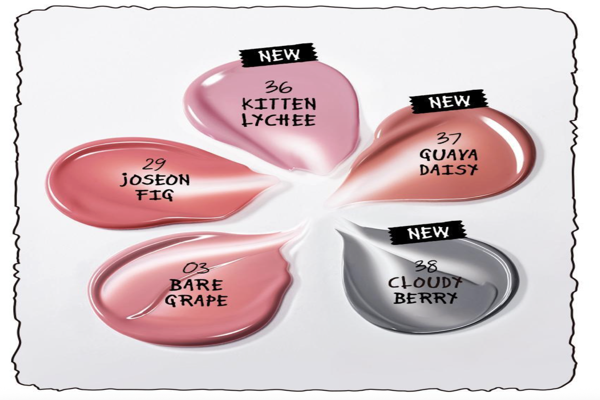

INSTRUCTIONS:
1. Use your mouse to paint the area of the image with the desired color.
2. Click the 'Save Drawing' button

👉 Once you have saved your drawing, please press Enter.

Drawing saved as 'lip_full_drawn_image.png'
Binary mask saved as lip_full_mask_binary.png.


/tmp/ipython-input-3486889469.py:132: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(roi_img, mode='RGBA')


ROI image saved as lip_full_roi.png.
Extracted color for lip_full: (212, 127, 135)

💋 Upload a lip_half item or example image you want to try on!


Saving lips_color.webp to lips_color (2).webp



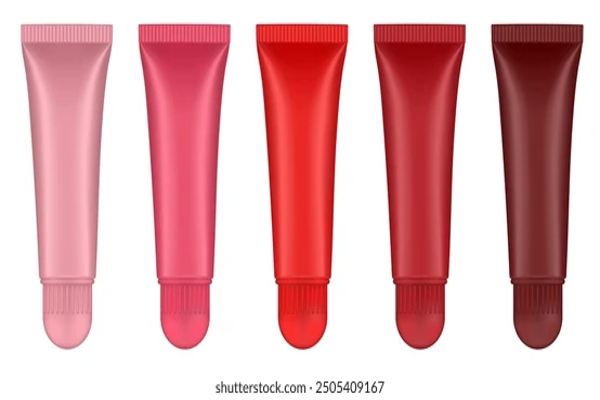

INSTRUCTIONS:
1. Use your mouse to paint the area of the image with the desired color.
2. Click the 'Save Drawing' button

👉 Once you have saved your drawing, please press Enter.

Drawing saved as 'lip_half_drawn_image.png'
Binary mask saved as lip_half_mask_binary.png.
ROI image saved as lip_half_roi.png.
Extracted color for lip_half: (183, 40, 48)

RGB Dict: {'lip_full': (212, 127, 135), 'lip_half': (183, 40, 48)}


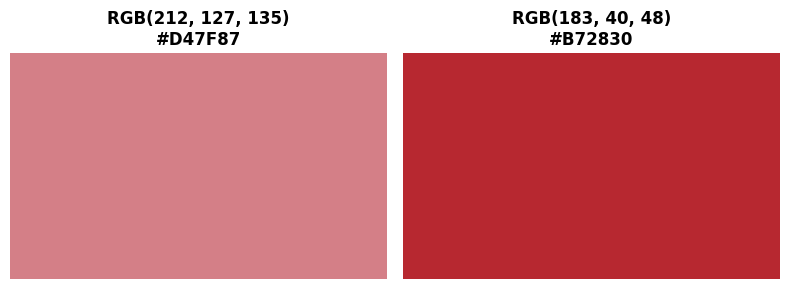

In [20]:
cosmetics = [
    c.strip()
    for c in input(
        "Which cosmetics do you want to extract colors for?\n"
        "Choose from: lip_full, lip_half, blush, "
        "eyeshadow_basic, eyeshadow_undereye, eyeshadow_triangle, eyebrow\n"
        "🚨 (separate by comma): "
    ).split(",")
]

rgb_dict = extract_color(cosmetics=cosmetics)
print(f"\nRGB Dict: {rgb_dict}")
render_color(rgb_dict)

###  2️⃣ Define your makeup parameters


**Parameter description**  

We have already set the alpha and sigma values to achieve a natural makeup appearance by default.

- **shape**
  - Please refer to the provided document for descriptions of the available shapes.

- **color (RGB)**
  - For shapes whose colors were previously extracted, the extracted colors are automatically applied.
  - If you do not want to use the extracted color, manually specify the color in the form `color = (R, G, B)` (e.g., `color = (200, 32, 108)`).

- **alpha (opacity)**
  - 0 means fully transparent, and 255 means fully opaque.
  - Increase the alpha value for more vivid colors, or decrease it for a more natural appearance.

- **sigma (Gaussian blur strength)**
  - Increasing this value results in a wider and softer spread of the color.

In [21]:
makeup_options = [
    # --- basic makeups ---
    MakeupOptions(
        shape=MakeupShape.LIP_FULL,
        color=rgb_dict.get("lip_full", (200, 32, 108)),
        alpha= 80,
        sigma= 5
    ),
    MakeupOptions(
        shape=MakeupShape.BLUSH_BASIC,
        color=rgb_dict.get("blush", (227, 155, 155)),
        alpha= 80,
        sigma= 40
    ),
    MakeupOptions(
        shape=MakeupShape.EYESHADOW_BASIC,
        color=rgb_dict.get("eyeshadow_basic", (210, 132, 132)),
        alpha= 80,
        sigma= 3
    ),

    # --- uncomment if you want to use ---
    # LIP
    MakeupOptions(
        shape=MakeupShape.LIP_HALF,
        color=rgb_dict.get("lip_half", (183, 6, 85)),
        alpha= 120,
        sigma= 7
    ),

    # --- uncomment if you want to use ---
    # LIP
    # MakeupOptions(
    #     shape=MakeupShape.LIP_HALF,
    #     color=rgb_dict.get("lip_half", (183, 6, 85)),
    #     alpha= 120,
    #     sigma= 7
    # ),

    # BLUSH
    # MakeupOptions(
    #     shape=MakeupShape.BLUSH_SUNKISSED,
    #     color=rgb_dict.get("blush", (227, 155, 155)),
    #     alpha= 60,
    #     sigma= 30
    # ),
    # MakeupOptions(
    #     shape=MakeupShape.BLUSH_CHIN,
    #     color=rgb_dict.get("blush", (227, 155, 155)),
    #     alpha= 120,
    #     sigma= 30
    # ),
    # MakeupOptions(
    #     shape=MakeupShape.BLUSH_NOSE,
    #     color=rgb_dict.get("blush", (227, 155, 155)),
    #     alpha= 90,
    #     sigma= 40
    # ),

    # EYESHADOW
    # MakeupOptions(
    #     shape=MakeupShape.EYESHADOW_UNDEREYE,
    #     color=rgb_dict.get("eyeshadow_undereye", (210, 168, 185)),
    #     alpha= 150,
    #     sigma= 10
    # ),
    # MakeupOptions(
    #     shape=MakeupShape.EYESHADOW_TRIANGLE,
    #     color=rgb_dict.get("eyeshadow_triangle", (152, 100, 97)),
    #     alpha= 100,
    #     sigma= 2
    # ),

    # EYEBROW
    # MakeupOptions(
    #     shape=MakeupShape.EYEBROW,
    #     color=rgb_dict.get("eyebrow", (140, 91, 86)),
    #     alpha= 50,
    #     sigma= 5
    # ),
]

### 3️⃣ Upload face image

In [22]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print("✅ Uploaded:", image_path)

Saving chehun.jpeg to chehun (2).jpeg
✅ Uploaded: chehun (2).jpeg


### 4️⃣ Check the results!

In [23]:
before = cv2.imread(image_path)
after = run_makeup(image_path, makeup_options)
cv2.imwrite("temp_after.jpg", after)

compare = show_before_after(before, after)

Output hidden; open in https://colab.research.google.com to view.

### 5️⃣ Apply additional matte texture for lips

In [24]:
def apply_matte_texture_region(image_bgr, lip_mask):
    img_orig = image_bgr.astype(np.float32)

    matte_img = cv2.bilateralFilter(image_bgr.astype(np.uint8), 9, 50, 50).astype(np.float32)
    lip_mask_3d = lip_mask[..., None]
    output = img_orig * (1 - lip_mask_3d) + matte_img * lip_mask_3d

    return output.astype(np.uint8)

In [25]:
landmarks = read_landmarks(before)

lip_mask = build_alpha_mask(before.shape, landmarks, MakeupOptions(
    shape=MakeupShape.LIP_FULL,
    color=(0,0,0),
    alpha=255,
    sigma=0
))

after_matte = apply_matte_texture_region(after, lip_mask)
compare_matte = show_before_after(after, after_matte, "BEFORE", "MATTE LIP")

Output hidden; open in https://colab.research.google.com to view.